In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#  for filename in filenames:
#      print(os.path.join(dirname, filename))

In [2]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl'
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl'
# !pip install effdet

Processing /kaggle/input/timm-package/timm-0.1.26-py3-none-any.whl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Processing /kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")

import json
import numpy as np
import pandas as pd
import cv2
import os
import re
from datetime import datetime
import time
import random

from PIL import Image
from tqdm import tqdm
from glob import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from sklearn.model_selection import StratifiedKFold


from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
TRAIN_ROOT_PATH = '/kaggle/input/train-dhaka-ai-and-poribohon-v2/train_p_2/'
IMG_SIZE = 512

train_image_path = TRAIN_ROOT_PATH


types = ('*.jpg','*.jpeg','*.png','*.JPG','*.PNG') # the tuple of file types
train_images = []
for type in types:
  train_images.extend(sorted(glob(train_image_path + type)))



print(f' train images : {len(train_images)} items')


 train images : 8237 items


In [5]:
from random import sample

def get_ids(path_list):
  path_list = random.sample(path_list,len(path_list))
  id_list = [path.split('/')[-1].split('.')[0] for path in path_list]
  return np.array(id_list)

train_ids = get_ids(train_images)


print(len(train_ids))
print(train_ids)

8237
['Dipto_ 186' 'Dipto_660' 'bus 370' ... 'Dipto_435' 'bicycle (659)'
 'bicycle (297)']


In [6]:
from sklearn import preprocessing
#getting the labels
marking_train = pd.read_csv('/kaggle/input/train-dhaka-ai-and-poribohon-v2/train_p_2/traincsv/train_p_2.csv')

wh_train = marking_train
wh_train['w'] = marking_train['xmax'] - marking_train['xmin']
wh_train['h'] = marking_train['ymax'] - marking_train['ymin']
wh_train = wh_train.drop(['xmax','ymax'], axis = 1)

wh_train = wh_train.rename(columns={"class" : "classname","width": "image_width", "height": "image_height", "xmin": "x", "ymin": "y"})
marking_train = wh_train
marking_train['image_id'] = marking_train['image_name']
for i in range(0,marking_train['image_name'].size) :
  marking_train['image_id'].iloc[i] = marking_train['image_name'].iloc[i].split('.')[0]
#marking_train = marking_train.drop(['image_name'], axis = 1)
le = preprocessing.LabelEncoder()
targets = le.fit_transform(marking_train['classname'].tolist())
marking_train['class_id'] = targets
marking_train = marking_train[['image_id','image_name','image_width','image_height','classname','class_id','x','y','w','h']]
marking_train = marking_train.drop(['image_name'], axis=1)
marking_train.head()

image_id  image_width  image_height classname  class_id    x    y    w    h
0       01         1200           800       bus         4  833  390  254  410
1       01         1200           800       bus         4  901  284  117  111
2       01         1200           800       bus         4  909  241  101   46
3       01         1200           800  rickshaw        13  761  413   71  127
4       01         1200           800  rickshaw        13  777  364   51   45

In [7]:
corrupt_files = ['113','114','118','231','Pias (359)', 'Pias (360)']

for i in corrupt_files :
  # Get indexes where name column has value i
  if marking_train[marking_train['image_id'] == i].index.any() :
    indexNames = marking_train[marking_train['image_id'] == i].index
    # Delete these row indexes from dataFrame
    marking_train.drop(indexNames , inplace=True)

marking_train.shape

(38805, 9)

In [8]:
#code for each vehicle
column_values = marking_train[["classname", "class_id"]].values.ravel()
unique_values = pd.unique(column_values)
print(unique_values)

['bus' 4 'rickshaw' 13 'motorbike' 10 'car' 5 'three wheelers (CNG)' 17
 'pickup' 11 'minivan' 9 'suv' 15 'van' 19 'taxi' 16 'truck' 18 'bicycle'
 3 'policecar' 12 'ambulance' 0 'human hauler' 7 'wheelbarrow' 20
 'minibus' 8 'auto rickshaw' 2 'army vehicle' 1 'scooter' 14 'garbagevan'
 6]


In [9]:
df = marking_train[(marking_train[['image_width']] != 0).all(axis=1)]
df.sort_values(by='image_width',ascending=True)
df.head()

image_id  image_width  image_height classname  class_id    x    y    w    h
0       01         1200           800       bus         4  833  390  254  410
1       01         1200           800       bus         4  901  284  117  111
2       01         1200           800       bus         4  909  241  101   46
3       01         1200           800  rickshaw        13  761  413   71  127
4       01         1200           800  rickshaw        13  777  364   51   45

In [10]:
df['x2'] = df['x'] + df['w'] 
df['y2'] = df['y'] + df['h']

df = df.rename(columns={'x' : 'x1', 'y' : 'y1'})
df = df.drop(columns=['class_id','w','h'])
df.head()

image_id  image_width  image_height classname   x1   y1    x2   y2
0       01         1200           800       bus  833  390  1087  800
1       01         1200           800       bus  901  284  1018  395
2       01         1200           800       bus  909  241  1010  287
3       01         1200           800  rickshaw  761  413   832  540
4       01         1200           800  rickshaw  777  364   828  409

In [11]:
df['classname'] = df['classname'].replace(['three_wheelers_(CNG)'],'three wheelers (CNG)')
df['classname'] = df['classname'].replace(['human_hauler'],'human hauler')
df['classname'] = df['classname'].replace(['auto_rickshaw'],'auto rickshaw')
df['classname'] = df['classname'].replace(['army_vehicle'],'army vehicle')
len(df['classname'].unique())

21

In [12]:
my_list = ['114','113','118','truck (683)','rickshaw (201)','truck (684)','truck (643)']

for i in my_list :
  df.drop(df.loc[df['image_id']==i].index, inplace=True)

In [13]:
class_map = dict(zip(df['classname'].unique(),list(range(1,22))))
print(df['classname'].unique())
pd.DataFrame(df['classname'].unique(),columns = ['classname']).to_csv('class.csv',index=False)

df['class'] = df['classname'].apply(lambda x : class_map[x])
# df['id'] = df['id'].astype(np.str)
df[['x1','y1','x2','y2']] = df[['x1','y1','x2','y2']].astype(np.float)
df = df.drop(index = df[df['x1']==df['x2']].index)
df.to_csv('train.csv',index=False)
# df = pd.read_csv('../input/facemask/train.csv')
df.head()

['bus' 'rickshaw' 'motorbike' 'car' 'three wheelers (CNG)' 'pickup'
 'minivan' 'suv' 'van' 'taxi' 'truck' 'bicycle' 'policecar' 'ambulance'
 'human hauler' 'wheelbarrow' 'minibus' 'auto rickshaw' 'army vehicle'
 'scooter' 'garbagevan']


image_id  image_width  image_height classname     x1     y1      x2     y2  \
0       01         1200           800       bus  833.0  390.0  1087.0  800.0   
1       01         1200           800       bus  901.0  284.0  1018.0  395.0   
2       01         1200           800       bus  909.0  241.0  1010.0  287.0   
3       01         1200           800  rickshaw  761.0  413.0   832.0  540.0   
4       01         1200           800  rickshaw  777.0  364.0   828.0  409.0   

   class  
0      1  
1      1  
2      1  
3      2  
4      2

In [14]:
df['class'].nunique()

21

In [15]:
df['image_id'].nunique()

8221

In [16]:
count = 0
ERROR_LIST = []
for id in train_ids:
    if id not in df['image_id'].unique():
        count = count+1
        ERROR_LIST.append(id)
print(count)
print(len(ERROR_LIST))

16
16


In [17]:
train_ids2 =set(train_ids) - set(ERROR_LIST)
print(len(train_ids))
print(len(train_ids2))

train_ids = train_ids2

8237
8221


In [18]:
# df = pd.read_csv('../input/facemask/FaceMask.csv')
# df = df.rename(columns = {'classname':'class'})
# df

In [19]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 0
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds.bbox_count)):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
    
# df_folds.to_csv('train_folds.csv',index=False)
# df_folds = pd.read_csv('../input/facemask/train_folds.csv')
df_folds.head()

bbox_count  fold
image_id                  
01                30     0
02                31     4
03                 5     0
04                15     4
05                34     9

In [20]:
def getExtension(filename):
  left = TRAIN_ROOT_PATH
  types = ('*.jpg','*.jpeg','*.png','*.JPG','*.PNG') # the tuple of file types
  train_images = []
  for type in types:
    train_images.extend(sorted(glob(TRAIN_ROOT_PATH + type)))
  for i in train_images:
    x = i
    x = x.split('.')[0]
    if filename == x:
        return i.lstrip(left+x)

In [21]:
print(getExtension(TRAIN_ROOT_PATH+'Dipto_532'))
print(getExtension(TRAIN_ROOT_PATH+'Navid_582'))

.JPG
.JPG


In [22]:
def get_train_transforms():
    return A.Compose(
        [
#             A.RandomSizedCrop(min_max_height=(256, 256), height=1024, width=1024, p=0.5),
            
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.01),
            A.RandomSizedBBoxSafeCrop(IMG_SIZE, IMG_SIZE, erosion_rate=0.0, interpolation=1, p=1.0),
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1),
            A.Cutout(num_holes=20, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            A.Blur(blur_limit=5, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625,scale_limit=0.1, rotate_limit=20 ,p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [23]:
LIST_OF_ERROR_IMAGES = []
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image, boxes, labels = self.load_image_and_boxes(index)
        
#         if self.test or random.random() > 0.5:
#             image, boxes = self.load_image_and_boxes(index)
#         else:
#             image, boxes = self.load_cutmix_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['img_scale'] = torch.tensor([1.])
        target['image_id'] = torch.tensor([index])
        target['img_size'] = torch.tensor([(IMG_SIZE, IMG_SIZE)])

        try :
          if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': target['labels']
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target['labels'] = torch.tensor(sample['labels'])
                    break

          return image, target, image_id
        except:
          print("\nERROR IN THIS IMAGE : ",image_id)
          LIST_OF_ERROR_IMAGES.append(image_id)
          
          image_id = self.image_ids[1]
          image, boxes, labels = self.load_image_and_boxes(1)
          
  #         if self.test or random.random() > 0.5:
  #             image, boxes = self.load_image_and_boxes(index)
  #         else:
  #             image, boxes = self.load_cutmix_image_and_boxes(index)
          
          target = {}
          target['boxes'] = boxes
          target['labels'] = labels
          target['img_scale'] = torch.tensor([1.])
          target['image_id'] = torch.tensor([index])
          target['img_size'] = torch.tensor([(IMG_SIZE, IMG_SIZE)])

          if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': target['labels']
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target['labels'] = torch.tensor(sample['labels'])
                    break

          return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        
        path = TRAIN_ROOT_PATH
        try:
            image_id = self.image_ids[index]
            ext = getExtension(str(path + image_id))
            image = cv2.imread(f'{path}/{image_id}{ext}', cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            records = self.marking[self.marking['image_id'] == image_id]
            boxes = records[['x1', 'y1', 'x2', 'y2']].values
            return image, boxes , records['class']
        except:
            image_id = self.image_ids[0]
            ext = getExtension(str(path + image_id))
            image = cv2.imread(f'{path}/{image_id}{ext}', cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            records = self.marking[self.marking['image_id'] == image_id]
            boxes = records[['x1', 'y1', 'x2', 'y2']].values
            return image, boxes , records['class']
        
            
        
        #return image, boxes , records['class']

In [24]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=df,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=df,
    transforms=get_valid_transforms(),
    test=True,
)

In [25]:
print(len(train_dataset))
print(len(validation_dataset))

7398
823


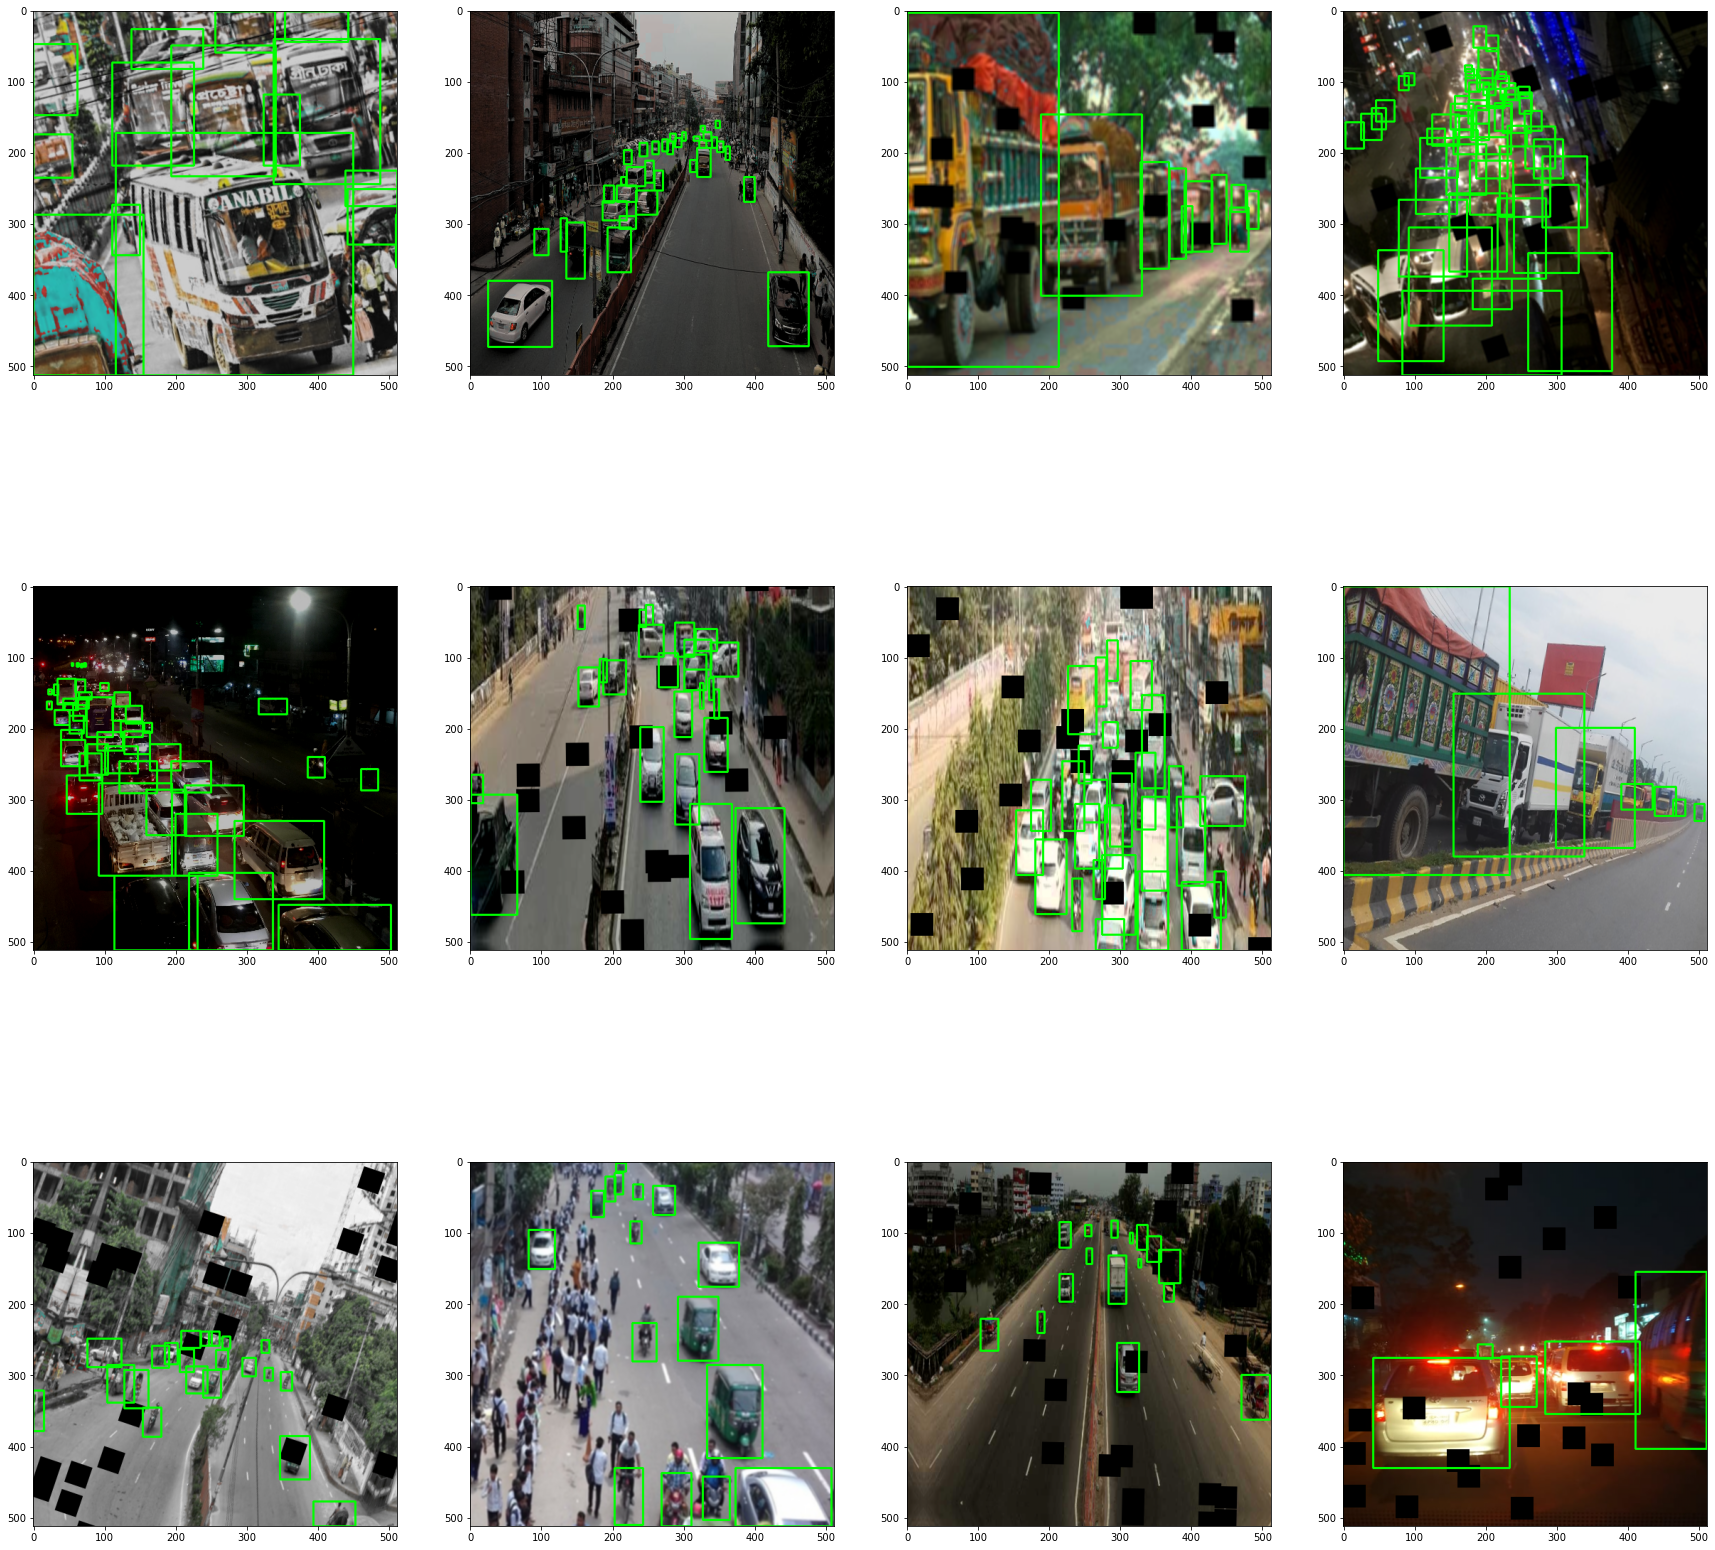

In [26]:
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 3

#c_map = dict(zip(list(range(1,21)),pd.read_csv('../input/facemask/classname.csv')['classname'].unique()))

for i in range(1, columns*rows +1):
    image, target, image_id = train_dataset[i]
    boxes = target['boxes'].cpu().numpy().astype(np.int32)
    classnames = target['labels'].cpu().numpy()
    numpy_image = image.permute(1,2,0).cpu().numpy()

    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(numpy_image)
plt.show()

In [27]:
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 3

#c_map = dict(zip(list(range(1,21)),pd.read_csv('../input/facemask/classname.csv')['classname'].unique()))

for i in range(1, columns*rows +1):
    image, target, image_id = validation_dataset[i]
    boxes = target['boxes'].cpu().numpy().astype(np.int32)
    classnames = target['labels'].cpu().numpy()
    numpy_image = image.permute(1,2,0).cpu().numpy()

    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(numpy_image)
plt.show()

In [28]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
class TrainGlobalConfig:
    num_workers = 8
    batch_size = 4
    n_epochs = 10
    lr = 0.001

    folder = 'effdet5pAug_im512_b4kag_checkpoint/'
    verbose = True
    verbose_step = 1
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.25,
        patience=2,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [30]:
class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
        
        self.load('../input/dhaka-ai-round2-effdet5paugi512b4/effdet5pAug_im512_b4kag_checkpoint/last-checkpoint.bin')

    def fit(self,df_folds,df):
        fold_number = 0
        for e in range(self.config.n_epochs):
            fold_number = (fold_number+1)%10

            train_dataset = DatasetRetriever(
                image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
                marking=df,
                transforms=get_train_transforms(),
                test=False,
            )

            validation_dataset = DatasetRetriever(
                image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
                marking=df,
                transforms=get_valid_transforms(),
                test=True,
            )
            
            train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=self.config.batch_size,
#               sampler=RandomSampler(train_dataset),
                shuffle=True,
                pin_memory=False,
                drop_last=True,
                num_workers=self.config.num_workers,
                collate_fn=collate_fn,
            )
            validation_loader = torch.utils.data.DataLoader(
                validation_dataset, 
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
                shuffle=False,
#         sampler=SequentialSampler(validation_dataset),
                pin_memory=False,
                collate_fn=collate_fn,
            )
            
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'LR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        
        tk0 =  tqdm(enumerate(val_loader),total = len(validation_dataset)/TrainGlobalConfig.batch_size)
        for step, (images, targets, image_ids) in tk0:
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    tk0.set_postfix( loss = summary_loss.avg)
                    
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        
        tk0 =  tqdm(enumerate(train_loader),total = int(len(train_dataset)/TrainGlobalConfig.batch_size))
        for step, (images, targets, image_ids) in tk0:
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    tk0.set_postfix( loss = summary_loss.avg)
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            '''
            print(images.shape)
            print(len(boxes))
            print(len(labels))
            '''

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training(df_folds,df):
    device = torch.device('cuda:0')
    net.to(device)

    

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(df_folds,df)

In [32]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=True)
#     checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
#     net.load_state_dict(checkpoint)
    config.num_classes = 21
    config.image_size = IMG_SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


In [33]:
run_training(df_folds,df)

Fitter prepared. Device is cuda:0
LR: 6.25e-05


100%|██████████| 1849/1849 [44:21<00:00,  1.44s/it, loss=0.256]


[RESULT]: Train. Epoch: 70, summary_loss: 0.25648, time: 2661.35918


100%|██████████| 206/205.75 [02:27<00:00,  1.40it/s, loss=0.218]


[RESULT]: Val. Epoch: 70, summary_loss: 0.21826, time: 147.49337
LR: 6.25e-05


100%|██████████| 1849/1849 [44:55<00:00,  1.46s/it, loss=0.254]


[RESULT]: Train. Epoch: 71, summary_loss: 0.25380, time: 2695.50388


100%|██████████| 206/205.75 [02:29<00:00,  1.38it/s, loss=0.222]

[RESULT]: Val. Epoch: 71, summary_loss: 0.22220, time: 149.62317
LR: 6.25e-05



100%|██████████| 1849/1849 [45:07<00:00,  1.46s/it, loss=0.256]


[RESULT]: Train. Epoch: 72, summary_loss: 0.25618, time: 2708.22331


100%|██████████| 206/205.75 [02:29<00:00,  1.38it/s, loss=0.222]

[RESULT]: Val. Epoch: 72, summary_loss: 0.22208, time: 149.48627
LR: 6.25e-05



100%|██████████| 1849/1849 [45:35<00:00,  1.48s/it, loss=0.251]


[RESULT]: Train. Epoch: 73, summary_loss: 0.25082, time: 2736.21078


100%|██████████| 206/205.75 [02:30<00:00,  1.37it/s, loss=0.216]


[RESULT]: Val. Epoch: 73, summary_loss: 0.21543, time: 151.08896
LR: 6.25e-05


100%|██████████| 1849/1849 [45:17<00:00,  1.47s/it, loss=0.253]


[RESULT]: Train. Epoch: 74, summary_loss: 0.25306, time: 2718.02406


100%|██████████| 206/205.75 [02:24<00:00,  1.42it/s, loss=0.216]

[RESULT]: Val. Epoch: 74, summary_loss: 0.21628, time: 145.04660
LR: 6.25e-05



100%|██████████| 1849/1849 [46:54<00:00,  1.52s/it, loss=0.249]


[RESULT]: Train. Epoch: 75, summary_loss: 0.24922, time: 2814.35835


100%|██████████| 206/205.75 [02:33<00:00,  1.34it/s, loss=0.224]

[RESULT]: Val. Epoch: 75, summary_loss: 0.22402, time: 153.54903
LR: 6.25e-05



100%|██████████| 1849/1849 [47:39<00:00,  1.55s/it, loss=0.251]


[RESULT]: Train. Epoch: 76, summary_loss: 0.25077, time: 2859.91147


100%|██████████| 206/205.75 [02:43<00:00,  1.26it/s, loss=0.21]


[RESULT]: Val. Epoch: 76, summary_loss: 0.21000, time: 163.80526
LR: 6.25e-05


100%|██████████| 1849/1849 [46:16<00:00,  1.50s/it, loss=0.247]


[RESULT]: Train. Epoch: 77, summary_loss: 0.24743, time: 2776.75602


100%|██████████| 206/205.75 [02:23<00:00,  1.44it/s, loss=0.219]

[RESULT]: Val. Epoch: 77, summary_loss: 0.21849, time: 143.33182
LR: 6.25e-05



100%|██████████| 1849/1849 [45:21<00:00,  1.47s/it, loss=0.249]


[RESULT]: Train. Epoch: 78, summary_loss: 0.24932, time: 2721.95917


100%|██████████| 206/205.75 [02:38<00:00,  1.30it/s, loss=0.215]

[RESULT]: Val. Epoch: 78, summary_loss: 0.21459, time: 158.73862
LR: 6.25e-05



100%|██████████| 1849/1849 [44:52<00:00,  1.46s/it, loss=0.247]


[RESULT]: Train. Epoch: 79, summary_loss: 0.24661, time: 2693.19119


100%|██████████| 206/205.75 [02:24<00:00,  1.42it/s, loss=0.218]

[RESULT]: Val. Epoch: 79, summary_loss: 0.21779, time: 145.16219
